In [1]:
# Importing necessary libraries from PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models, datasets
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import torch.nn.functional as F
import numpy as np

# Importing other necessary packages
import numpy as np
from PIL import Image

# Optional: for visualization and additional utilities
import matplotlib.pyplot as plt


# Load Pre-trained Model

In [2]:
from torchvision import models
import torch.nn as nn

# Load the pretrained MobileNetV3 model
model = models.mobilenet_v3_large(pretrained=True)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# Print the model architecture
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# Step 1: Load the data

In [4]:
from dataset_prep import *

In [5]:
# PARAMS
BATCH_SIZE = 200
NUM_WORKERS = 8
PIN_MEMORY = False
SHUFFLE = False # preprocessed data is already shuffled
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
PATIENCE = 5
# NUM_BATCHES = 10 this one when want to break early, train just one batch etc.
LOAD_MODEL = False

In [6]:
# Base path
base_path = '/Users/ruimaciel/Desktop/Barcelona/DL_Image/Final_project/data_prepped'

# Define the datasets with correct paths
train_ds = Prepped_Painting_Dataset(data_dir=os.path.join(base_path, 'train_prep'))
valid_ds = Prepped_Painting_Dataset(data_dir=os.path.join(base_path, 'val_prep'))
test_ds = Prepped_Painting_Dataset(data_dir=os.path.join(base_path, 'test_prep'))


train_loader = DataLoader(train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)


valid_loader = DataLoader(valid_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)


test_loader = DataLoader(test_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=SHUFFLE,
                          persistent_workers=True)

# Step 2: Unfreeze the Last Layer

In [7]:
# Assuming you have 'num_classes' as the number of your target classes
num_classes = 27  # Change this to your number of classes

# Replace the classifier - note for MobileNetV3, the final classifier is named 'classifier'
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

# Step 3: Move the Model to a GPU (Optional)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cpu


# Step 4: Define Loss Function and Optimizer

In [9]:
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.01)  # Add L2 regularization


# Step 5: Training the Model

In [10]:
# model.train()  # Set the model to training mode
# num_epochs = 5  # Number of training epochs

# # Lists to track losses
# train_losses = []
# val_losses = []

# for epoch in range(num_epochs):
#     # Training phase
#     model.train()  # Ensure the model is in training mode
#     running_train_loss = 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

#         # Convert labels to one-hot encoding
#         labels = torch.nn.functional.one_hot(labels.squeeze(), num_classes=26).float()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()  # Clear gradients w.r.t. parameters
#         loss.backward()  # Backward pass
#         optimizer.step()  # Perform a single optimization step

#         running_train_loss += loss.item()

#     epoch_train_loss = running_train_loss / len(train_loader)
#     train_losses.append(epoch_train_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}')

#     # Validation phase
#     model.eval()  # Set the model to evaluation mode
#     running_val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in valid_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             # Convert labels to one-hot encoding
#             labels = torch.nn.functional.one_hot(labels.squeeze(), num_classes=26).float()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             running_val_loss += loss.item()

#     epoch_val_loss = running_val_loss / len(valid_loader)
#     val_losses.append(epoch_val_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}')

# # Plotting training and validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
# plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()


In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
# # Define the learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=1e-6)

# # Training and validation loops
# num_epochs = 20  # Number of training epochs
# patience = 2    # Number of epochs to wait for improvement
# min_delta = 0.01  # Minimum change to qualify as an improvement

# # Lists to track losses
# train_losses = []
# val_losses = []

# # Early stopping variables
# best_val_loss = float('inf')
# early_stop_counter = 0
# best_model_params = None

# for epoch in range(num_epochs):
#     # Training phase
#     model.train()  # Ensure the model is in training mode
#     running_train_loss = 0.0
#     loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")

#     for inputs, labels in loop:
#         inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

#         # Ensure labels are 1D tensors of class indices
#         if labels.ndimension() > 1:
#             labels = labels.squeeze()

#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()  # Clear gradients w.r.t. parameters
#         loss.backward()  # Backward pass
#         optimizer.step()  # Perform a single optimization step

#         running_train_loss += loss.item()
#         loop.set_postfix(loss=loss.item())

#     epoch_train_loss = running_train_loss / len(train_loader)
#     train_losses.append(epoch_train_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_train_loss:.4f}')

#     # Validation phase
#     model.eval()  # Set the model to evaluation mode
#     running_val_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in valid_loader:
#             inputs, labels = inputs.to(device), labels.to(device)

#             # Ensure labels are 1D tensors of class indices
#             if labels.ndimension() > 1:
#                 labels = labels.squeeze()

#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             running_val_loss += loss.item()

#     epoch_val_loss = running_val_loss / len(valid_loader)
#     val_losses.append(epoch_val_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}')

#     # Adjust the learning rate based on the validation loss
#     scheduler.step(epoch_val_loss)

#     # Early stopping check
#     if epoch_val_loss < best_val_loss - min_delta:
#         best_val_loss = epoch_val_loss
#         early_stop_counter = 0
#         best_model_params = model.state_dict().copy()  # Save the best model parameters
#         print("Validation loss improved. Resetting early stopping counter and saving model parameters.")
#     else:
#         early_stop_counter += 1
#         print(f"No improvement in validation loss. Early stopping counter: {early_stop_counter}")

#     if early_stop_counter >= patience:
#         print("Early stopping triggered. Stopping training.")
#         break

# # Load the best model parameters before plotting
# if best_model_params is not None:
#     model.load_state_dict(best_model_params)
#     print("Loaded best model parameters from training.")

# # Plotting training and validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
# plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()



# Step 6: Evaluate the Model

In [13]:
# import torch
# import torch.nn as nn
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# # Inference with Softmax and Metrics Calculation on Test Dataset
# model.eval()  # Set the model to evaluation mode
# softmax = nn.Softmax(dim=1)
# all_labels = []
# all_predictions = []

# with torch.no_grad():
#     for inputs, labels in test_loader:  # Assume you have a DataLoader 'test_loader'
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         probabilities = softmax(outputs)  # Apply softmax to get probabilities
#         _, predicted = torch.max(probabilities, 1)  # Get the index of the max probability
#         all_labels.extend(labels.cpu().numpy())
#         all_predictions.extend(predicted.cpu().numpy())

# # Calculate accuracy
# accuracy = accuracy_score(all_labels, all_predictions) * 100
# print(f'Overall Accuracy of the model on the test images: {accuracy:.2f}%')

# # Calculate precision, recall, f1-score, and support for each class
# precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)

# # Print precision, recall, f1-score, and accuracy for each class
# for i in range(num_classes):
#     class_precision = precision[i]
#     class_recall = recall[i]
#     class_f1 = f1[i]
#     class_support = support[i]
#     class_accuracy = 100 * (np.sum((np.array(all_labels) == i) & (np.array(all_predictions) == i))) / class_support
#     print(f'Class {i}:')
#     print(f'  Precision: {class_precision:.4f}')
#     print(f'  Recall: {class_recall:.4f}')
#     print(f'  F1 Score: {class_f1:.4f}')
#     print(f'  Accuracy: {class_accuracy:.2f}%')

# # Print overall precision, recall, f1-score
# overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
# print(f'Overall Precision: {overall_precision:.4f}')
# print(f'Overall Recall: {overall_recall:.4f}')
# print(f'Overall F1 Score: {overall_f1:.4f}')

# # Print classification report
# print("\nClassification Report:")
# print(classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)]))



## Another optimizer

# Unfreezing another layer

In [14]:

# Freeze all layers except the last two
for param in model.parameters():
    param.requires_grad = False

# Define the new classifier with dropout and the final linear layer
new_classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.Dropout(0.2),  # Add dropout before the final layer
    nn.Linear(model.classifier[0].out_features, num_classes)  # Add the final linear layer
)

model.classifier = new_classifier

# Unfreeze the last two layers
for param in model.classifier[-2:].parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.03, momentum=0.9, weight_decay=0.01)

cpu


Epoch [1/20] Training: 100%|██████████| 111/111 [12:09<00:00,  6.57s/it, loss=2.73]

Epoch [1/20], Training Accuracy: 0.1580


Epoch [1/20], Validation Accuracy: 0.3220
Validation accuracy improved. Resetting early stopping counter and saving model parameters.


Epoch [2/20] Training: 100%|██████████| 111/111 [12:12<00:00,  6.60s/it, loss=2.62]


Epoch [2/20], Training Accuracy: 0.2423
Epoch [2/20], Validation Accuracy: 0.3575
Validation accuracy improved. Resetting early stopping counter and saving model parameters.


Epoch [3/20] Training: 100%|██████████| 111/111 [12:43<00:00,  6.88s/it, loss=2.55]


Epoch [3/20], Training Accuracy: 0.2643
Epoch [3/20], Validation Accuracy: 0.3554
No improvement in validation accuracy. Early stopping counter: 1


Epoch [4/20] Training: 100%|██████████| 111/111 [12:51<00:00,  6.95s/it, loss=2.5] 


Epoch [4/20], Training Accuracy: 0.2774
Epoch [4/20], Validation Accuracy: 0.3590
No improvement in validation accuracy. Early stopping counter: 2


Epoch [5/20] Training: 100%|██████████| 111/111 [12:51<00:00,  6.95s/it, loss=2.47]


Epoch [5/20], Training Accuracy: 0.2873
Epoch [5/20], Validation Accuracy: 0.3634
No improvement in validation accuracy. Early stopping counter: 3


Epoch [6/20] Training: 100%|██████████| 111/111 [12:54<00:00,  6.98s/it, loss=2.43]


Epoch [6/20], Training Accuracy: 0.2968
Epoch [6/20], Validation Accuracy: 0.3666
No improvement in validation accuracy. Early stopping counter: 4


Epoch [7/20] Training: 100%|██████████| 111/111 [12:59<00:00,  7.03s/it, loss=2.39]


Epoch [7/20], Training Accuracy: 0.3071
Epoch [7/20], Validation Accuracy: 0.3716
Validation accuracy improved. Resetting early stopping counter and saving model parameters.


Epoch [8/20] Training: 100%|██████████| 111/111 [12:57<00:00,  7.00s/it, loss=2.39]


Epoch [8/20], Training Accuracy: 0.3155
Epoch [8/20], Validation Accuracy: 0.3754
No improvement in validation accuracy. Early stopping counter: 1


Epoch [9/20] Training: 100%|██████████| 111/111 [12:57<00:00,  7.01s/it, loss=2.37]


Epoch [9/20], Training Accuracy: 0.3270
Epoch [9/20], Validation Accuracy: 0.3883
Validation accuracy improved. Resetting early stopping counter and saving model parameters.


Epoch [10/20] Training: 100%|██████████| 111/111 [12:59<00:00,  7.02s/it, loss=2.34]


Epoch [10/20], Training Accuracy: 0.3383
Epoch [10/20], Validation Accuracy: 0.3951
No improvement in validation accuracy. Early stopping counter: 1


Epoch [11/20] Training: 100%|██████████| 111/111 [12:59<00:00,  7.03s/it, loss=2.37]


Epoch [11/20], Training Accuracy: 0.3494
Epoch [11/20], Validation Accuracy: 0.3998
Validation accuracy improved. Resetting early stopping counter and saving model parameters.


Epoch [12/20] Training: 100%|██████████| 111/111 [12:54<00:00,  6.98s/it, loss=2.31]


Epoch [12/20], Training Accuracy: 0.3600
Epoch [12/20], Validation Accuracy: 0.4001
No improvement in validation accuracy. Early stopping counter: 1


Epoch [13/20] Training: 100%|██████████| 111/111 [12:55<00:00,  6.99s/it, loss=2.29]


Epoch [13/20], Training Accuracy: 0.3764
Epoch [13/20], Validation Accuracy: 0.3998
No improvement in validation accuracy. Early stopping counter: 2


Epoch [14/20] Training: 100%|██████████| 111/111 [12:59<00:00,  7.02s/it, loss=2.29]


Epoch [14/20], Training Accuracy: 0.3827
Epoch [14/20], Validation Accuracy: 0.3995
No improvement in validation accuracy. Early stopping counter: 3


Epoch [15/20] Training: 100%|██████████| 111/111 [12:55<00:00,  6.98s/it, loss=2.25]


Epoch [15/20], Training Accuracy: 0.3914
Epoch [15/20], Validation Accuracy: 0.3992
No improvement in validation accuracy. Early stopping counter: 4


Epoch [16/20] Training: 100%|██████████| 111/111 [12:54<00:00,  6.98s/it, loss=2.26]


Epoch [16/20], Training Accuracy: 0.3904
Epoch [16/20], Validation Accuracy: 0.3992
No improvement in validation accuracy. Early stopping counter: 5
Early stopping triggered. Stopping training.
Loaded best model parameters from training.


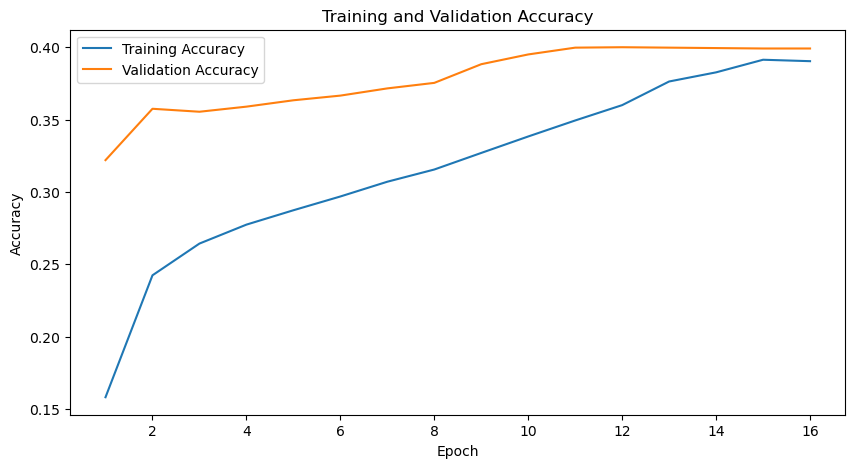

In [15]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

# Training and validation loops
num_epochs = 20
patience = 5
min_delta = 0.01

train_accuracies = []
val_accuracies = []

best_val_accuracy = 0.0
early_stop_counter = 0
best_model_params = None

for epoch in range(num_epochs):
    model.train()
    running_corrects_train = 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training")

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        if labels.ndimension() > 1:
            labels = labels.squeeze()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.classifier[-1].parameters(), max_norm=1.0)
        
        optimizer.step()
        running_corrects_train += torch.sum(preds == labels.data)
        loop.set_postfix(loss=loss.item())

    epoch_train_accuracy = running_corrects_train.double() / len(train_loader.dataset)
    train_accuracies.append(epoch_train_accuracy.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {epoch_train_accuracy:.4f}')

    model.eval()
    running_corrects_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if labels.ndimension() > 1:
                labels = labels.squeeze()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_corrects_val += torch.sum(preds == labels.data)

    epoch_val_accuracy = running_corrects_val.double() / len(valid_loader.dataset)
    val_accuracies.append(epoch_val_accuracy.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {epoch_val_accuracy:.4f}')

    scheduler.step()

    if epoch_val_accuracy > best_val_accuracy + min_delta:
        best_val_accuracy = epoch_val_accuracy
        early_stop_counter = 0
        best_model_params = model.state_dict().copy()
        print("Validation accuracy improved. Resetting early stopping counter and saving model parameters.")
    else:
        early_stop_counter += 1
        print(f"No improvement in validation accuracy. Early stopping counter: {early_stop_counter}")

    if early_stop_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

if best_model_params is not None:
    model.load_state_dict(best_model_params)
    print("Loaded best model parameters from training.")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Overall Accuracy of the model on the test images: 39.92%
Class Impressionism:
  Precision: 0.3714
  Recall: 0.1287
  F1 Score: 0.1912
  Accuracy: 592800.00%
Class Expressionism:
  Precision: 0.2711
  Recall: 0.3850
  F1 Score: 0.3182
  Accuracy: 299364.00%
Class Abstract_Expressionism:
  Precision: 0.2778
  Recall: 0.2750
  F1 Score: 0.2764
  Accuracy: 299364.00%
Class Symbolism:
  Precision: 0.5000
  Recall: 0.2364
  F1 Score: 0.3210
  Accuracy: 1088596.36%
Class Color_Field_Painting:
  Precision: 0.3710
  Recall: 0.4100
  F1 Score: 0.3895
  Accuracy: 299364.00%
Class Ukiyo_e:
  Precision: 0.5000
  Recall: 0.4250
  F1 Score: 0.4595
  Accuracy: 299364.00%
Class Post_Impressionism:
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  Accuracy: 2138314.29%
Class High_Renaissance:
  Precision: 0.7297
  Recall: 0.6000
  F1 Score: 0.6585
  Accuracy: 1330506.67%
Class Realism:
  Precision: 0.5369
  Recall: 0.7569
  F1 Score: 0.6282
  Accuracy: 415783.33%
Class Pop_Art:
  Precision: 0.42

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class Romanticism:
  Precision: 0.4365
  Recall: 0.5500
  F1 Score: 0.4867
  Accuracy: 299364.00%
Class Fauvism:
  Precision: 0.2598
  Recall: 0.2650
  F1 Score: 0.2624
  Accuracy: 299364.00%
Class Synthetic_Cubism:
  Precision: 0.4430
  Recall: 0.2023
  F1 Score: 0.2778
  Accuracy: 346085.55%
Class Baroque:
  Precision: 0.5050
  Recall: 0.6667
  F1 Score: 0.5746
  Accuracy: 391325.49%
Class Cubism:
  Precision: 0.4470
  Recall: 0.4504
  F1 Score: 0.4487
  Accuracy: 457044.27%
Class Analytical_Cubism:
  Precision: 0.6667
  Recall: 0.0513
  F1 Score: 0.0952
  Accuracy: 1535200.00%
Class Pointillism:
  Precision: 0.3491
  Recall: 0.3304
  F1 Score: 0.3394
  Accuracy: 534578.57%
Class Northern_Renaissance:
  Precision: 0.3770
  Recall: 0.5900
  F1 Score: 0.4600
  Accuracy: 299364.00%
Class Mannerism_Late_Renaissance:
  Precision: 1.0000
  Recall: 0.1111
  F1 Score: 0.2000
  Accuracy: 6652533.33%
Class Contemporary_Realism:
  Precision: 0.5234
  Recall: 0.6667
  F1 Score: 0.5864
  Accuracy

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


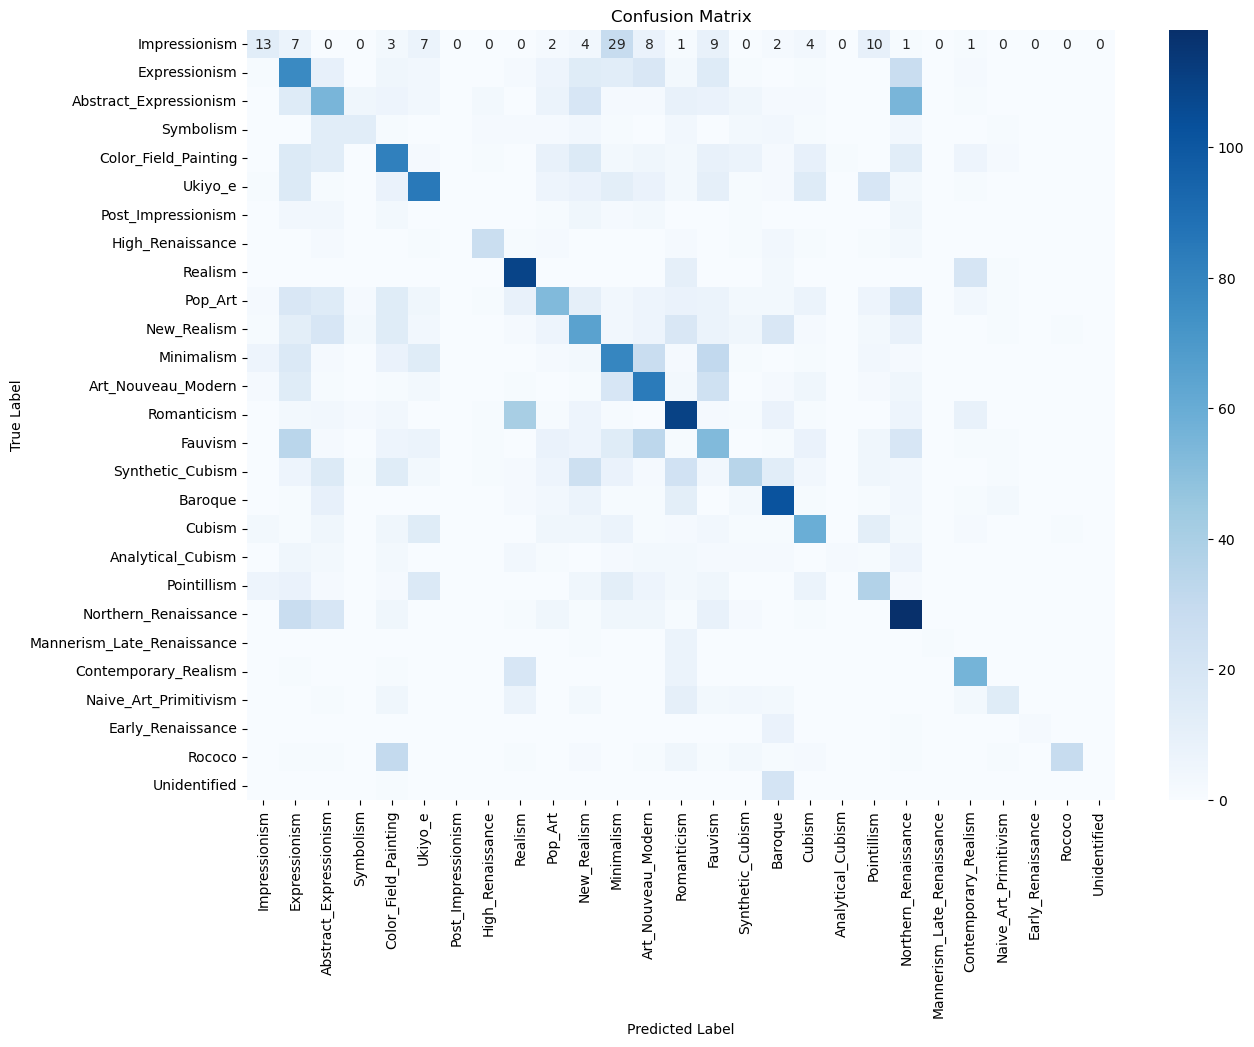

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Define the label to art movement mapping
label_mapping = {0: 'Impressionism', 1: 'Expressionism', 2: 'Abstract_Expressionism', 3: 'Symbolism', 4: 'Color_Field_Painting', 
                 5: 'Ukiyo_e', 6: 'Post_Impressionism', 7: 'High_Renaissance', 8: 'Realism', 9: 'Pop_Art', 10: 'New_Realism', 
                 11: 'Minimalism', 12: 'Art_Nouveau_Modern', 13: 'Romanticism', 14: 'Fauvism', 15: 'Synthetic_Cubism', 
                 16: 'Baroque', 17: 'Cubism', 18: 'Analytical_Cubism', 19: 'Pointillism', 20: 'Northern_Renaissance', 
                 21: 'Mannerism_Late_Renaissance', 22: 'Contemporary_Realism', 23: 'Naive_Art_Primitivism', 
                 24: 'Early_Renaissance', 25: 'Rococo', 26: 'Unidentified'}

# Inference with Softmax and Metrics Calculation
model.eval()  # Set the model to evaluation mode
softmax = torch.nn.Softmax(dim=1)
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in valid_loader:  # Assume you have a DataLoader 'valid_loader'
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = softmax(outputs)  # Apply softmax to get probabilities
        _, predicted = torch.max(probabilities, 1)  # Get the index of the max probability
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_predictions) * 100
print(f'Overall Accuracy of the model on the test images: {accuracy:.2f}%')

# Calculate precision, recall, f1-score, and support for each class
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_predictions, average=None)

# Print precision, recall, f1-score, and accuracy for each class
num_classes = len(label_mapping)
for i in range(num_classes):
    class_accuracy = 100 * (np.array(all_labels) == np.array(all_predictions)).sum() / support[i]
    print(f'Class {label_mapping[i]}:')
    print(f'  Precision: {precision[i]:.4f}')
    print(f'  Recall: {recall[i]:.4f}')
    print(f'  F1 Score: {f1[i]:.4f}')
    print(f'  Accuracy: {class_accuracy:.2f}%')

# Optionally, you can print the overall precision, recall, f1-score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
print(f'Overall Precision: {overall_precision:.4f}')
print(f'Overall Recall: {overall_recall:.4f}')
print(f'Overall F1 Score: {overall_f1:.4f}')

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_mapping[i] for i in range(num_classes)], 
            yticklabels=[label_mapping[i] for i in range(num_classes)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
